In [32]:
import qif
import fbleau
import numpy as np
import pandas as pd

from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from causalgraphicalmodels import StructuralCausalModel

import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [55]:
display(HTML("<style>.container { width:50% !important; }</style>"))

In [2]:
# Support functions
def bernoulli(p, size=None):
    """p = P(x=1)"""
    return np.random.binomial(n=1, p=p, size=size)


def _z_channel(x, flip):
    if x == 0:
        return 0
    else:
        return bernoulli(1-flip)
    

def _direct_channel(x):
    return x


def _symmetric_channel(x, flip):
    if x == 0:
        return bernoulli(flip)
    else:
        return bernoulli(1 - flip)
    
    
def _xor_channel(x1, x2):
    if x1 == x2:
        return bernoulli(0)
    else:
        return bernoulli(1)
    

def _pxor_channel(x1, x2, flip):
    if x1 == x2:
        return bernoulli(flip)
    else:
        return bernoulli(1 - flip)
    

def _and_channel(x1, x2):
    if x1 == x2 == 1:
        return bernoulli(1)
    else:
        return bernoulli(0)
    

def _pand_channel(x1, x2, flip):
    if x1 == x2 == 1:
        return bernoulli(1 - flip)
    else:
        return bernoulli(flip)
    

def _or_channel(x1, x2):
    if x1 == x2 == 0:
        return bernoulli(0)
    else:
        return bernoulli(1)
    

def _por_channel(x1, x2, flip):
    if x1 == x2 == 0:
        return bernoulli(flip)
    else:
        return bernoulli(1 - flip)


def node_function(x, p=0.9):
    if x == 0:
        return x
    else:
        return np.random.binomial(n=1, p=p)
    
    
def joint_distribution(df, x, y):
    joint_dist = df.groupby([x, y]).size().unstack()
    joint_dist.columns = joint_dist.columns.get_level_values(0)
    joint_dist = joint_dist.div(joint_dist.sum().sum())
    return joint_dist.fillna(0)

In [3]:
# Graph function
def one_variable_channel(x, flip=0.5, name='z'):
    if name == 'z':
        return _z_channel(x, flip)
    elif name == 'direct':
        return _direct_channel(x)
    elif name == 'symmetric':
        return _symmetric_channel(x, flip)
    else:
        raise NameError('Function not valid')
    
    
def two_variables_channel(x1, x2, flip=0.5, name='xor'):
    if name == 'xor':
        return _xor_channel(x1, x2)
    elif name == 'pxor':
        return _pxor_channel(x1, x2, flip)
    elif name == 'and':
        return _and_channel(x1, x2)
    elif name == 'pand':
        return _pand_channel(x1, x2, flip)
    elif name == 'or':
        return _or_channel(x1, x2)
    elif name == 'por':
        return _por_channel(x1, x2, flip)
    else:
        raise NameError('Function not valid')

In [4]:
# Entropy functions
def guessing_entropy(l):
    """ Return the Shannon entropy of random variable with probability vector l"""
    tmp = l.sort_values(ascending=False)
    return sum([p*i for (i,p) in enumerate(l)]) + 1


def shannon_entropy(l):
    return entropy(l, base=2)


def joint_shannon_entropy(joint):
    return shannon_entropy(joint.values.flatten())


def conditional_shannon_entropy(joint, axis=1):
    X = joint.sum(axis=axis)
    Y_given_X = joint.div(X, axis=1)
    ent = 0
    for x in X.index:
        if axis == 1:
            tmp = Y_given_X.loc[x]
        else:
            tmp = Y_given_X[x]
        ent += X.loc[x] * entropy(tmp, base=2)   
    return ent


def mutual_information(joint, axis=0):
    Y = joint.sum(axis=axis)
    return shannon_entropy(Y) - conditional_shannon_entropy(joint, axis=1-axis)

In [5]:
# Fbleau setup
def fbleau_train_test_split(df, x, y, reverse=False):
    if reverse:
        Y = df[y]
        X = df[x]
    else:
        Y = df[x]
        X = df[y]
        
    X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.5)
    X_train = X_train.reshape(-1, 1).astype(np.float64)
    X_test = X_test.reshape(-1, 1).astype(np.float64)
    y_train = y_train.astype(np.uint64)
    y_test = y_test.astype(np.uint64)
    
    return X_train, X_test, y_train, y_test


def fbleau_bayes_risk(df, x, y, estimate='nn'):
    # direct
    X_train, X_test, y_train, y_test = fbleau_train_test_split(df, x, y)
    result = fbleau.run_fbleau(X_train, y_train, X_test,
              y_test, estimate=estimate, log_errors=False,
              log_individual_errors=False, delta=None, qstop=None,
              absolute=False, scale=False)
    direct_bayes_risk = result['min-estimate']
    
    # reverse
    X_train, X_test, y_train, y_test = fbleau_train_test_split(df, x, y, reverse=True)
    result = fbleau.run_fbleau(X_train, y_train, X_test,
              y_test, estimate=estimate, log_errors=False,
              log_individual_errors=False, delta=None, qstop=None,
              absolute=False, scale=False)
    reverse_bayes_risk = result['min-estimate']
    
    return direct_bayes_risk, reverse_bayes_risk

In [6]:
# Compute attributes
def test_suite(df):
    data = {}
    joint = joint_distribution(df, x='X', y='Y')
    
    # Classical entropy measures
    data['shannon_entropy_X'] = shannon_entropy(joint.sum(axis=1))
    data['shannon_entropy_Y'] = shannon_entropy(joint.sum(axis=0))
    data['joint_shannon_entropy'] = joint_shannon_entropy(joint)
    data['conditional_shannon_entropy_X|Y'] = conditional_shannon_entropy(joint, axis=0)
    data['conditional_shannon_entropy_Y|X'] = conditional_shannon_entropy(joint, axis=1)
    data['mutual_information'] = mutual_information(joint, axis=0)
    data['guessing_entropy_X'] = guessing_entropy(joint.sum(axis=1))
    data['guessing_entropy_Y'] = guessing_entropy(joint.sum(axis=0))
    
    # Bayes Vulnerability
    bayes = qif.BayesLeakage(df)
    data['mult_avg_dir_flow'], data['mult_avg_rev_flow'] = bayes.compute_flows(x='X', y='Y')
    data['mult_max_dir_flow'], data['mult_max_rev_flow'] = bayes.compute_flows(x='X', y='Y', vulnerability_type='max')
    data['addt_avg_dir_flow'], data['addt_avg_rev_flow'] = bayes.compute_flows(x='X', y='Y', leakage_type='additive')
    data['addt_max_dir_flow'], data['addt_max_rev_flow'] = bayes.compute_flows(x='X', y='Y', leakage_type='additive', vulnerability_type='max')
    
    # Bayes Risk
    data['direct_bayes_risk'], data['reverse_bayes_risk'] = fbleau_bayes_risk(df, x='X', y='Y')
    return data

In [8]:
# Setup
one_var_list = ['z', 'direct', 'symmetric']
two_var_list = ['xor', 'pxor', 'and', 'pand', 'or', 'por']
dist = [0, 0.25, 0.5, 0.75, 1]
n_runs = 30

# Aliases
choice = np.random.choice

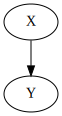

In [7]:
basic_causal = StructuralCausalModel({
    "X": lambda    n_samples: np.random.binomial(n=1, p=p, size=n_samples),
    "Y": lambda X, n_samples: np.array(list(map(one_variable_channel, X, np.array([p_flip] * n_samples), np.array([func] * n_samples)))),
})

basic_causal.cgm.draw()

In [12]:
basic_causal_flows = []
for p in dist:
    for p_flip in dist:
        for func in one_var_list:
            for _ in range(n_runs):
                df = basic_causal.sample(2000)
                basic_causal_dict = test_suite(df)
                basic_causal_dict['p'] = p
                basic_causal_dict['p_flip'] = p_flip
                basic_causal_dict['func'] = func
                basic_causal_dict['name'] = 'basic_causal'
                basic_causal_flows.append(basic_causal_dict)

In [13]:
basic_causal_df = pd.DataFrame(basic_causal_flows)

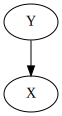

In [17]:
basic_anticausal = StructuralCausalModel({
    "Y": lambda    n_samples: np.random.binomial(n=1, p=p, size=n_samples),
    "X": lambda Y, n_samples: np.array(list(map(one_variable_channel, Y, np.array([p_flip] * n_samples), np.array([func] * n_samples)))),
})

basic_anticausal.cgm.draw()

In [18]:
basic_anticausal_flows = []
for p in dist:
    for p_flip in dist:
        for func in one_var_list:
            for _ in range(n_runs):
                df = basic_anticausal.sample(2000)
                basic_anticausal_dict = test_suite(df)
                basic_anticausal_dict['p'] = p
                basic_anticausal_dict['p_flip'] = p_flip
                basic_anticausal_dict['func'] = func
                basic_anticausal_dict['name'] = 'basic_anticausal'
                basic_anticausal_flows.append(basic_anticausal_dict)

In [20]:
basic_anticausal_df = pd.DataFrame(basic_anticausal_flows)

In [21]:
df = pd.concat([basic_causal_df, basic_anticausal_df])

In [74]:
df2 = df.query("p_flip <= 0.5 and func == 'z'")

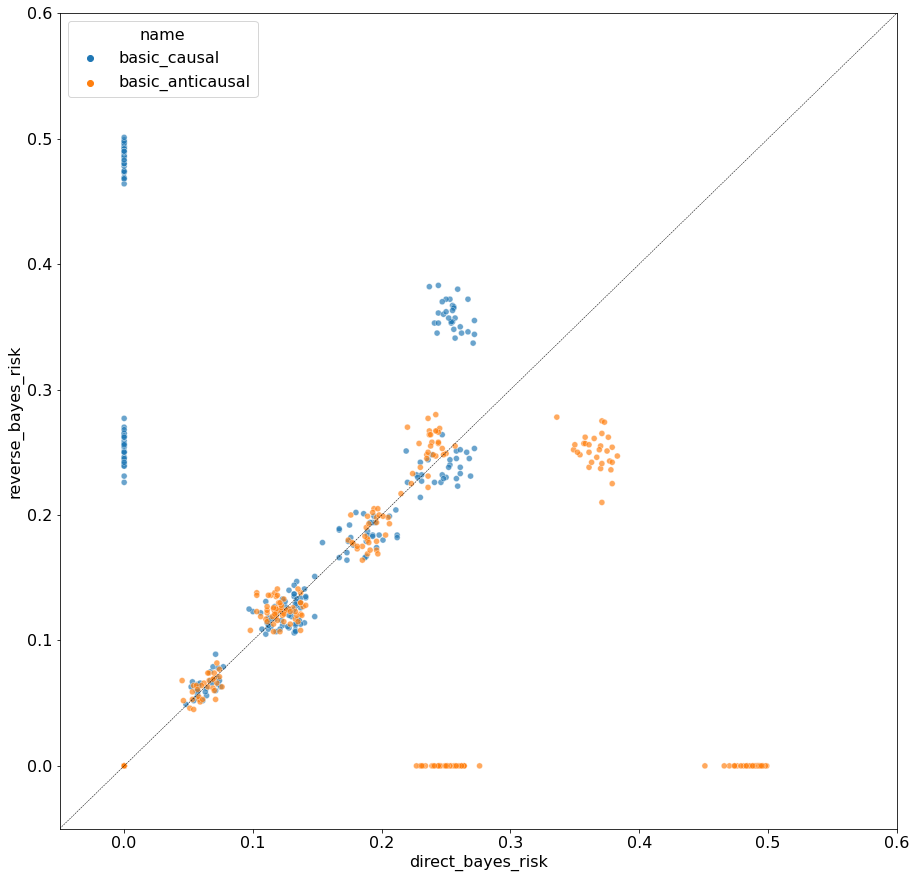

In [75]:
plt.figure(figsize=(15, 15))

sns.scatterplot(data=df2, x='direct_bayes_risk', y='reverse_bayes_risk', hue='name', alpha=2/3)
plt.plot([-.05, 0.6], [-.05, 0.6], color='black', linewidth=0.5, linestyle='dashed')
plt.ylim([-.05, 0.6])
plt.xlim([-.05, 0.6])

plt.show()

In [62]:
df['func'].unique()

array(['z', 'direct', 'symmetric'], dtype=object)